In [1]:
import sys
import os
import json
sys.path.append(os.path.expanduser('~/git/experiments-2025'))
sys.path.append(os.path.expanduser('~/git/TrON'))

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

from matplotlib.path import Path
from matplotlib.patches import PathPatch

%matplotlib ipympl

import bumps
from bumps.fitters import fit
import refl1d
print(refl1d.__version__)
from refl1d.names import *

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
try:
    from bumps import dream
    HAS_BUMPS  = True
except:
    print("No bumps")
    HAS_BUMPS = False

if HAS_BUMPS:
    from tron.bayesian_analysis import fit_uncertainties
    importlib.reload(fit_uncertainties)

from tron.bayesian_analysis import summary_plots

1.0.0a17


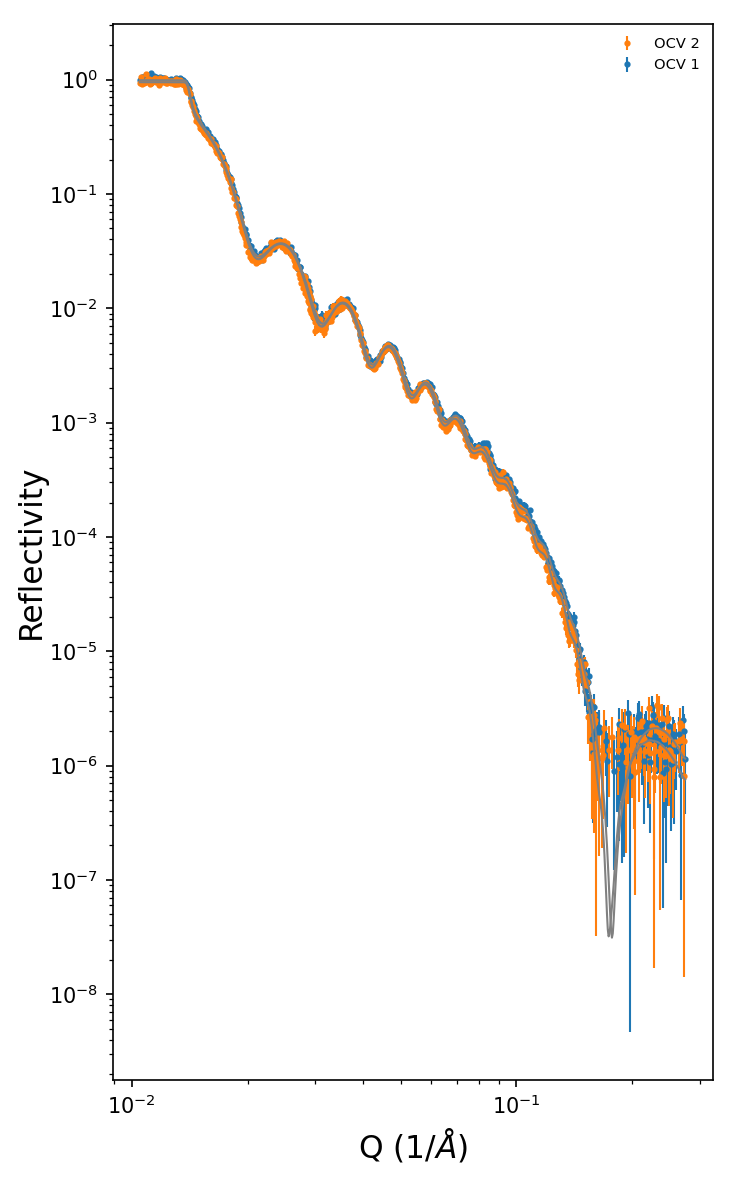

In [ ]:
results_dir = os.path.expanduser('~/git/experiments-2025/jen-apr2025/results')

def plot_fit(file, title='', scale=1):
    _data = np.loadtxt(os.path.join(results_dir, file)).T

    idx = _data[3] < _data[2]
    plt.errorbar(_data[0][idx], _data[2][idx]*scale, yerr=_data[3][idx]*scale, linewidth=1, 
                 markersize=4, marker='.', linestyle='', label=title)
    
    plt.plot(_data[0], _data[4]*scale, linewidth=1, markersize=2, marker='', color='grey', zorder=4)


fig, ax = plt.subplots(dpi=150, figsize=(5,8))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)

plot_fit('expt1-ocv1/Cu-THF-1-refl.dat', 'OCV 1', scale=1)
plot_fit('expt1-ocv2/Cu-THF-1-refl.dat', 'OCV 2', scale=10)
plot_fit('expt1-ocv2/Cu-THF-1-refl.dat', 'OCV 2', scale=100)
#plot_fit('r213592/CuSi-1-refl.dat', 'r213592 - 0.7 V', scale=10)
#plot_fit('r213595/CuSi-1-refl.dat', 'r213595 - 0.05 V', scale=10)
#plot_fit('r213598/CuSi-1-refl.dat', 'r213598 - 0.05 V', scale=100)
#plot_fit('r213601/CuSi-1-refl.dat', 'r213601 - 0.7 V', scale=1000)






handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 7})
plt.xlabel('Q ($1/\AA$)', fontsize=15)
plt.ylabel('Reflectivity', fontsize=15)
plt.yscale('log')
plt.xscale('log')
ax.yaxis.labelpad = 1


In [5]:
os.path.expanduser('~/git/experiments-2025/jen-apr2025/results')

json_file = os.path.join(results_dir, 'expt1-ocv1', 'Cu-THF.json')


from bumps.serialize import load_file
from refl1d.bumps_interface import fitplugin

bumps.cli.install_plugin(fitplugin)

problem = load_file(json_file)

expt = list(problem.models)[0]
#print(expt)

from bumps import serialize
expt_json = os.path.join(results_dir, 'expt1-ocv1', 'Cu-THF-1-expt.json')
with open(expt_json, "rt") as input_file:
    serialized = input_file.read()
    serialized_dict = json.loads(serialized)
    expt = serialize.deserialize(serialized_dict, migration=True)


final version:  bumps-draft-03


/SNS/users/m2d/git/TrON/tron/bayesian_analysis/summary_plots.py


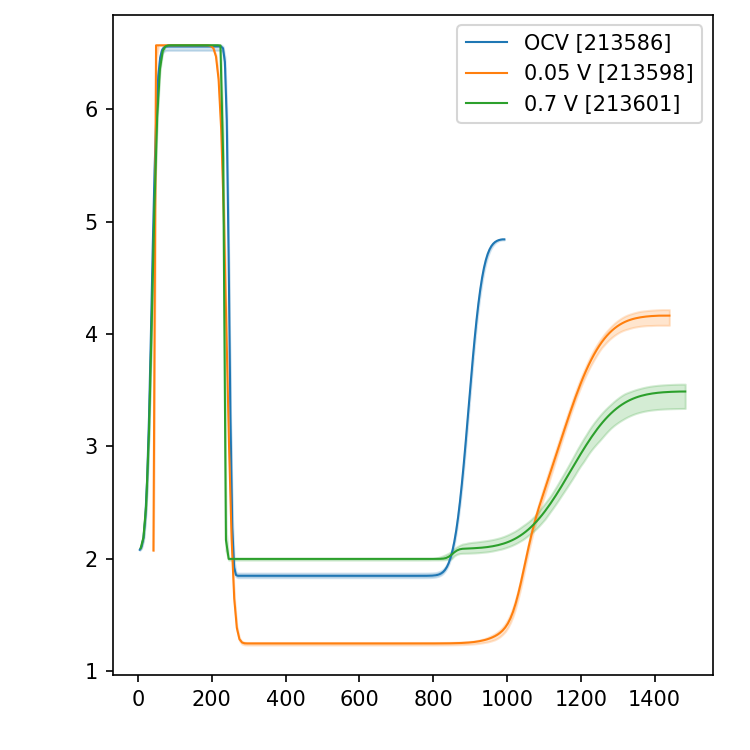

In [ ]:
importlib.reload(summary_plots)
print(summary_plots.__file__)

import bumps
from bumps import dream

fig, ax = plt.subplots(dpi=150, figsize=(5,5))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)

    
profile_file = os.path.join(results_dir, 'expt1-ocv1', 'Cu-THF-1-profile.dat')
summary_plots.plot_sld(profile_file, 'OCV 1', show_cl=True)

profile_file = os.path.join(results_dir, 'expt1-ocv2', 'Cu-THF-1-profile.dat')
summary_plots.plot_sld(profile_file, 'OCV 2', show_cl=True, z_offset=35)

profile_file = os.path.join(results_dir, 'expt1-ocv3', 'Cu-THF-1-profile.dat')
summary_plots.plot_sld(profile_file, 'OCV 3', show_cl=True)

plt.legend()


In [19]:
ocv_thick = 650
V_si = 22.5 # 19.8
V_li = 14.7
b_si = 41.5
b_li = -19

#sld = (b_si + x * b_li)/(V_si + x * V_li)

rho = 1.24

x = ( rho * V_si - b_si ) / (b_li - rho * V_li)

thickness = ocv_thick * (1 + x * V_li / V_si)

print(thickness)


def capacity_from_charge(charge, ocv_thick, li_loss=0):
    """
        @param charge: integrated charge array in mAh
        @param ocv_thick: initial thickness in Angstroms
        
        Charge array is: Ewe/V   time/s   I/mA   (Q-Qo)/mA.h
    """
    V_si = 19.8
    V_li = 14.7
    b_si = 41.5
    b_li = -19

    si_density = 2.33 # g/cm3
    anode_area = 15.2 # cm2
    si_molar_mass = 28
    N_A = 6.022e23
    coulomb = 1.6022e-19
    
    # Number of Si atoms
    n_si = si_density * anode_area * ocv_thick * 1e-8 * N_A / si_molar_mass
    
    # Number of Li atoms
    n_li_no_loss = -charge[3] * 3600e-3 / coulomb
    n_li = -charge[3] * 3600e-3 / coulomb * (1.0 - li_loss)
    
    x = n_li/n_si
    sld = (b_si + x * b_li)/(V_si + x * V_li)
    thickness = ocv_thick * (1 + x * V_li / V_si)
    
    print("Charge:    %g" % charge[3][-1])
    print("x w/loss:  %g" % (n_li/n_si)[-1])
    print("x no loss: %g" % (n_li_no_loss/n_si)[-1])
    return x, sld, thickness

805.137709967408
